In [1]:
import os
import random
import numpy as np
import onnxruntime as ort
from pathlib import Path
from itertools import accumulate
from PIL import Image
import torch
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights
from pymilvus import connections, Collection, FieldSchema, CollectionSchema, DataType, utility
import abc
from tqdm import tqdm
import logging

# --- ログの設定 ---
if False:
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.INFO)
    handler = logging.StreamHandler()  # コンソール出力用ハンドラ
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
else:
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.CRITICAL)

# --- Milvusマネージャクラス ---
class MilvusManager:
    def __init__(self, uri, collection_name, index_params, dim, max_length=256, recreate=True):
        """
        Milvusへの接続とコレクションの作成/再作成を行います。

        :param uri: MilvusサーバのURI（例: "./milvus_demo.db"）
        :param collection_name: コレクション名（例: "image_embeddings"）
        :param index_params: インデックス作成用パラメータ
        :param dim: 埋め込みベクトルの次元数（例: 2048）
        :param max_length: file_pathフィールドの最大文字数
        :param recreate: Trueなら既存コレクションがあれば削除して再作成
        """
        self.uri = uri
        self.collection_name = collection_name
        self.index_params = index_params
        self.dim = dim
        self.max_length = max_length
        self.connection_alias = "default"
        self.collection = None
        self.connect()
        self.create_or_get_collection(recreate)
        
    def connect(self):
        connections.connect(self.connection_alias, uri=self.uri)
        logger.info(f"Milvusに接続しました。URI: {self.uri}")

    def create_or_get_collection(self, recreate):
        if utility.has_collection(self.collection_name):
            if recreate:
                utility.drop_collection(self.collection_name)
                logger.info(f"既存のコレクション '{self.collection_name}' を削除しました。")
                self.create_collection()
            else:
                self.collection = Collection(self.collection_name)
                logger.info(f"既存のコレクション '{self.collection_name}' を利用します。")
        else:
            self.create_collection()

    def create_collection(self):
        fields = [
            FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=True),
            FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=self.dim),
            FieldSchema(name="file_path", dtype=DataType.VARCHAR, max_length=self.max_length)
        ]
        schema = CollectionSchema(fields, description="画像埋め込みコレクション (Image Embedding Collection)")
        self.collection = Collection(name=self.collection_name, schema=schema)
        logger.info(f"コレクション '{self.collection_name}' を作成しました。")
        self.create_index()

    def create_index(self):
        self.collection.create_index(field_name="embedding", index_params=self.index_params)
        logger.info("インデックスを作成しました。")

    def insert_embeddings(self, data):
        """
        data は各行が辞書形式（例: {"embedding": [...], "file_path": "パス"}）のリストです。
        """
        self.collection.insert(data)
        self.collection.flush()
        logger.info("データを挿入しました。")

# --- 画像特徴抽出基底クラス ---
class BaseFeatureExtractor(abc.ABC):
    @abc.abstractmethod
    def extract_feature(self, image_path):
        """
        画像ファイルから特徴を抽出する抽象メソッド。
        :param image_path: 画像ファイルのパス（文字列）
        :return: 特徴ベクトル（NumPy配列）
        """
        pass

# --- 画像特徴抽出クラス ---
class ImageFeatureExtractor(BaseFeatureExtractor):
    def __init__(self, device=None):
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        from torchvision.models import ResNet50_Weights  # インポート場所に注意
        self.model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.model.fc = torch.nn.Identity()  # 全結合層を除去して2048次元出力に
        self.model.eval()
        self.model.to(self.device)
        self.preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.dim = 2048
        logger.info(f"ImageFeatureExtractor を初期化しました。device: {self.device}")

    def extract_feature(self, image_path):
        try:
            img = Image.open(image_path).convert("RGB")
        except Exception as e:
            logger.error(f"画像の読み込みに失敗しました。path: {image_path} error: {e}")
            raise
        img_tensor = self.preprocess(img).unsqueeze(0).to(self.device)
        with torch.no_grad():
            feature = self.model(img_tensor)
        feature_np = feature.cpu().numpy().flatten()
        norm = np.linalg.norm(feature_np)
        if norm > 0:
            feature_np = feature_np / norm
        return feature_np

# --- ONNX版画像特徴抽出クラス ---
class ONNXImageFeatureExtractor(BaseFeatureExtractor):
    def __init__(self, onnx_path, device=None):
        """
        ONNXモデルから特徴抽出を行うクラスです。
        ONNXモデルの出力次元（全結合層除去後の次元）を自動的に取得し、self.dim として保持します。

        :param onnx_path: エクスポート済みONNXモデルのパス
        :param device: 使用デバイス ("cuda" または "cpu")。指定がなければ自動判定します。
        """
        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = device

        # デバイスに合わせた ExecutionProvider の指定
        provider = "CUDAExecutionProvider" if device.lower() == "cuda" else "CPUExecutionProvider"
        self.session = ort.InferenceSession(onnx_path, providers=[provider])

        # ONNXモデルの入力メタデータからサイズ情報を取得
        inputs = self.session.get_inputs()
        if len(inputs) == 0:
            logger.error("ONNXモデルに入力が見つかりません。")
            raise ValueError("ONNX model has no inputs.")
        if len(inputs) > 1:
            logger.warning("ONNXモデルの入力が複数あります。最初の入力を使用します。")
        self.input_name = inputs[0].name
        self.input_shape = inputs[0].shape  # 例: [None, 3, 224, 224] または [1, 3, 224, 224]
        self.input_type = inputs[0].type
        logger.info(f"ONNX model input: name={self.input_name}, shape={self.input_shape}, type={self.input_type}")

        # 入力形状から対象サイズを抽出（動的な次元はNoneまたは-1ならデフォルト値を利用）
        default_size = 224
        # self.input_shapeは[batch, channels, height, width]の想定
        target_height = self.input_shape[2] if isinstance(self.input_shape[2], int) and self.input_shape[2] > 0 else default_size
        target_width  = self.input_shape[3] if isinstance(self.input_shape[3], int) and self.input_shape[3] > 0 else default_size

        # 前処理の作成：ResizeとCenterCropでONNXモデルの入力サイズに合わせる
        self.preprocess = transforms.Compose([
            # ここでは短辺がmax(target_height, target_width)になるようにリサイズし、
            # その後中央を指定サイズでクロップする
            transforms.Resize(max(target_height, target_width)),
            transforms.CenterCrop((target_height, target_width)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        ])

        # 出力次元（バッチ次元を除く）を自動で取得し、self.dim に保持
        self.dim = self._compute_output_dim()
        logger.info(f"モデルの出力次元: {self.dim}")

    def _compute_output_dim(self):
        """
        ONNXモデルの出力形状から、バッチ次元を除く各次元の積を計算して出力次元を求めます。
        動的次元が含まれる場合は、ダミー入力を用いて実際の出力形状から計算します。
        """
        output_shape = self.session.get_outputs()[0].shape

        # バッチ次元を除いた次元が全て整数ならその積を返す
        try:
            dims = [int(d) for d in output_shape[1:]]
            dim = np.prod(dims)
            return int(dim)
        except Exception as e:
            logger.warning(f"出力形状に動的次元が含まれています: {output_shape}. ダミー入力で出力次元を計算します。")
            # ダミー入力の形状: 入力形状の動的次元は 1 と仮定
            dummy_input_shape = [1 if not isinstance(x, int) else x for x in self.input_shape]
            dummy_input = np.random.rand(*dummy_input_shape).astype(np.float32)
            output = self.session.run(None, {self.input_name: dummy_input})[0]
            dim = np.prod(output.shape[1:])  # バッチ次元を除く
            return int(dim)

    def extract_feature(self, image_path):
        """
        画像ファイルを読み込み、前処理後にONNXモデルで推論を実行し、
        L2正規化した特徴ベクトル（NumPy配列、次元は self.dim ）を返します。

        :param image_path: 画像ファイルのパス（文字列）
        :return: 正規化された特徴ベクトル（NumPy 配列）
        """
        try:
            img = Image.open(image_path).convert("RGB")
        except Exception as e:
            logger.error(f"画像の読み込みに失敗しました。path: {image_path} error: {e}")
            raise

        # torchvision と同じ前処理を適用
        img_tensor = self.preprocess(img).unsqueeze(0).numpy()
        # ONNXセッションで推論を実行（入力名は self.input_name を使用）
        output = self.session.run(None, {self.input_name: img_tensor})
        feature = output[0].flatten()
        norm = np.linalg.norm(feature)
        if norm > 0:
            feature = feature / norm
        return feature

# --- 画像データの登録 ---
def register_images(image_dir_path, milvus_manager, extractor):
    """
    指定ディレクトリ内（再帰的探索）にある画像ファイル（.jpg, .jpeg, .png）を対象に、
    特徴抽出を行い、Milvusに登録します。

    :param image_dir_path: 画像ファイルが格納されているディレクトリのパス
    :param milvus_manager: MilvusManager のインスタンス
    :param extractor: BaseFeatureExtractor を継承した画像特徴抽出クラスのインスタンス
    """
    image_dir = Path(image_dir_path)
    image_file_paths = [str(f) for f in image_dir.glob("**/*") if f.suffix.lower() in (".jpg", ".jpeg", ".png")]
    logger.info(f"{len(image_file_paths)} 件の画像ファイルを検出しました。")
    
    rows = []  # 各行は {"embedding": [...], "file_path": "パス"} の辞書形式
    for image_file_path in tqdm(image_file_paths):
        try:
            feat = extractor.extract_feature(image_file_path)
            rows.append({
                "embedding": feat.tolist(),
                "file_path": image_file_path
            })
        except Exception as e:
            logger.error(f"特徴抽出エラー: {image_file_path} - {e}")
    milvus_manager.insert_embeddings(rows)
    logger.info("画像登録が完了しました。")

# --- 画像検索 ---
def search_images(collection, extractor, query_image_path, target_height=150, limit=5, nprobe=10, show_result=True):
    """
    指定ディレクトリからランダムにクエリ画像を選び、特徴抽出→Milvus検索→結果画像の連結表示を行います。
    
    :param collection: Milvus の Collection インスタンス
    :param extractor: BaseFeatureExtractor を継承した画像特徴抽出クラスのインスタンス
    :param query_image_path: クエリ画像のパス
    :param target_height: 表示時の画像高さ（ピクセル）
    :param limit: 検索結果の上位件数
    :param nprobe: 検索パラメータ nprobe の値
    :param show_result: 結果の表示有無。Falseの場合はコンソールやNotebook上に結果を表示せず、結果（results）のみを返却する。
    """
    
    query_image_path = Path(query_image_path)
    if show_result:
        print(f"検索に使用する画像: {query_image_path}")
    
    # 特徴抽出
    query_feature = extractor.extract_feature(str(query_image_path))
    
    # クエリ画像のリサイズと表示（アスペクト比を維持）
    query_img = Image.open(query_image_path)
    aspect_ratio = query_img.width / query_img.height
    query_img_resized = query_img.resize((int(target_height * aspect_ratio), target_height))
    if show_result:
        query_img_resized.show()
    
    # 検索パラメータの設定
    search_params = {
        "metric_type": "COSINE",
        "params": {"nprobe": nprobe}
    }
    
    # Milvusで検索
    results = collection.search(
        data=[query_feature.tolist()],
        anns_field="embedding",
        param=search_params,
        limit=limit,
        output_fields=["id", "file_path"]
    )
    
    if results and results[0]:
        if show_result:
            print(f"検索結果: 一致度 {results[0][0].distance}")
    else:
        if show_result:
            print("検索結果が見つかりませんでした。")
        return results
    
    hit_file_paths = [hit.entity.get("file_path") for hit in results[0]]
    
    # 検索結果画像の連結表示
    imgs = [Image.open(file_path) for file_path in hit_file_paths]
    resized_imgs = [
        img.resize((int(img.width * target_height / img.height), target_height), Image.LANCZOS)
        for img in imgs
    ]
    total_width = sum(img.width for img in resized_imgs)
    concat_img = Image.new("RGB", (total_width, target_height))
    positions = [0] + list(accumulate(img.width for img in resized_imgs))
    for x, im in zip(positions, resized_imgs):
        concat_img.paste(im, (x, 0))
    if show_result:
        concat_img.show()
    
    # 詳細結果のログ出力
    if show_result:
        for i, hits in enumerate(results):
            print(f"クエリ {i} の結果:")
            for hit in hits:
                print(f"  ID: {hit.id}, 距離: {hit.distance}, ファイルパス: {hit.entity.get('file_path')}")
    
    return results


In [ ]:
# 画像特徴抽出器の初期化
# extractor = ImageFeatureExtractor()
# extractor = ONNXImageFeatureExtractor(onnx_path="./model/mobilenet_v2.onnx")
# extractor = ONNXImageFeatureExtractor(onnx_path="./model/inception-v3-q.onnx")
# extractor = ONNXImageFeatureExtractor(onnx_path="./model/inception-v3.onnx")
# extractor = ONNXImageFeatureExtractor(onnx_path="./model/squeezenet1.0-12-int8.onnx")
# extractor = ONNXImageFeatureExtractor(onnx_path="./model/shufflenet-v2-12-int8.onnx")
extractor = ONNXImageFeatureExtractor(onnx_path="./model/shufflenet-v2-12-int8.onnx")

# Milvusの設定
uri = "./milvus_demo.db"
collection_name = "image_embeddings"
index_params = {
    "index_type": "IVF_FLAT",   # 倒立ファイルフラット
    "metric_type": "COSINE",      # コサイン類似度
    "params": {"nlist": 128}
}
dim = extractor.dim
# 既存のコレクションを削除して再作成する（recreate=True）
milvus_manager = MilvusManager(uri, collection_name, index_params, dim, recreate=True)

# 画像データの登録
registration_dir = "../../sample_data/coco_sample_datasets/"
logger.info("画像の登録を開始します。")
register_images(registration_dir, milvus_manager, extractor)

100%|██████████| 100/100 [00:00<00:00, 113.70it/s]


検索に使用する画像: ../../sample_data/coco_sample_datasets/sample_coco_train2017/000000188139.jpg


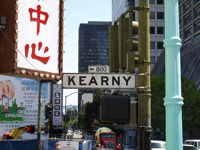

検索結果: 一致度 1.0000001192092896


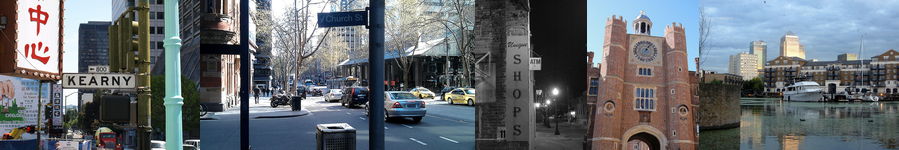

クエリ 0 の結果:
  ID: 455855141147902606, 距離: 1.0000001192092896, ファイルパス: ../../sample_data/coco_sample_datasets/sample_coco_train2017/000000188139.jpg
  ID: 455855141147902594, 距離: 0.45672792196273804, ファイルパス: ../../sample_data/coco_sample_datasets/sample_coco_train2017/000000188165.jpg
  ID: 455855141147902624, 距離: 0.43032312393188477, ファイルパス: ../../sample_data/coco_sample_datasets/sample_coco_train2017/000000544222.jpg
  ID: 455855141147902578, 距離: 0.1962914764881134, ファイルパス: ../../sample_data/coco_sample_datasets/sample_coco_train2017/000000188132.jpg
  ID: 455855141147902650, 距離: 0.19058719277381897, ファイルパス: ../../sample_data/coco_sample_datasets/sample_coco_train2017/000000544396.jpg


In [7]:
# 画像検索
query_img_path = random.choice(list(Path("../../sample_data").glob("**/*.jpg")))
logger.info("画像検索を開始します。")
_ = search_images(milvus_manager.collection, extractor, query_img_path, target_height=150, limit=5, nprobe=10, show_result=True)


In [ ]:
# 実行時間の計測
import time

test_num = 100
query_img_paths = [random.choice(list(Path("../../sample_data/coco_sample_datasets/sample_coco_train2017/").glob("**/*.jpg"))) for _ in range(test_num)]


start = time.time()
for img_path in tqdm(query_img_paths):
    search_images(milvus_manager.collection, extractor, img_path, target_height=150, limit=5, nprobe=10, show_result=False)
end = time.time()

print(f"1000回の検索にかかった時間: {end - start:.3f} 秒")
print(f"1回あたりの平均時間: {(end - start) / 1000:.8f} 秒")
